In [317]:
import re
import patsy
import pickle

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils

from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV

import warnings

In [318]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None and categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [319]:
def crossValidation(data, formula, split_num = 5, iter_num = 5, debug = False):
    rmsd_sum = 0
    r2_sum = 0
    num_iter=0
    
    df_Y, df_X = patsy.dmatrices(formula, data=data, return_type='dataframe')
    
    for idx in range(iter_num):
        df_cv_train_Y, df_cv_test_Y, df_cv_train_X, df_cv_test_X = train_test_split(df_Y, df_X, test_size=len(df_train)//split_num)

        model = sm.OLS(df_cv_train_Y, df_cv_train_X)
        result = model.fit()

        predict = result.predict(df_cv_test_X).values[:, np.newaxis]
        target = df_cv_test_Y.values
        
        # get rmsd
        square_y = (predict - target) ** 2
        rmsd = np.sqrt(square_y.sum() / len(df_cv_test_Y))
        
        # get r2
        r2 = r2_score(target, predict)
        
        if debug == True:
            print("{}차 시도!!!".format(num_iter+1))
            print("rmsd : ", rmsd)
            print("r2 : ", r2)
            print()

        rmsd_sum += rmsd
        r2_sum += r2
        num_iter +=1
    
    rmsd_avr = rmsd_sum / iter_num
    r2_avr = r2_sum / iter_num
    
    return rmsd_avr, r2_avr

# read file

In [320]:
df_train = pd.read_csv("data/train_no_missing.csv")
df_test = pd.read_csv("data/test_no_missing.csv")

nuTocaList = ["MSSubClass", "MoSold", "YrSold", "OverallQual", "OverallCond"]
df_train[nuTocaList] = df_train[nuTocaList].astype("str")
df_test[nuTocaList] = df_test[nuTocaList].astype("str")

df_all = pd.concat([df_train, df_test])
df_all.reset_index(drop = True, inplace = True)

df_all = pd.get_dummies(df_all)
df_train_dummy = df_all.iloc[:1460]
df_test_dummy = df_all.iloc[1460:]

df_train_dummy.reset_index(drop=True, inplace =True)
df_test_dummy.reset_index(drop=True, inplace =True)

df_test_dummy.drop("SalePriceLog", axis = 1, inplace = True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [321]:
df_train.shape, df_test.shape, df_train_dummy.shape, df_test_dummy.shape

((1460, 81), (1459, 80), (1460, 351), (1459, 350))

# 0. Preprocessing

## 0-1. Missing value Treatment

In [322]:
df_na = pd.read_csv("data/total_missing.csv")

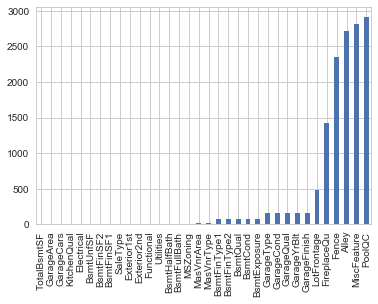

In [323]:
df_missing = df_na.isnull().sum()
df_missing = df_missing[df_missing > 0]
df_missing.sort_values(inplace = True)
df_missing.plot(kind = "bar")

In [324]:
df_missing.head()

TotalBsmtSF    1
GarageArea     1
GarageCars     1
KitchenQual    1
Electrical     1
dtype: int64

### 0-1-1. PoolQC

In [325]:
df_na[df_na["PoolQC"].notnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1170,1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,...,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,0,480,Gd,NaN,NaN,0,1,2008,New,Partial
1386,1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,...,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1423,1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,...,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1974,1975,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,...,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2573,2574,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,...,0,228,Ex,NaN,NaN,0,8,2007,WD,Normal
2710,2711,80,RL,100.0,14330,Pave,NaN,IR1,Low,AllPub,...,0,800,Gd,GdPrv,NaN,0,1,2006,WD,Normal


#### PoolArea가 0인 경우 

- PoolQC: None category
- Pool Area가 있음에도 PoolQC가 Na인 경우는 mode 값 

In [326]:
df_na["PoolArea"] != 0
df_pool = df_na[df_na["PoolArea"] != 0]

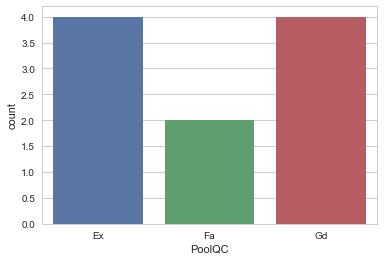

In [327]:
sns.countplot(df_na["PoolQC"])

#### PoolArea가 0인 아닌 경우
- Overall Qual 변수는 집 전체 상태를 본 값으로 수영장이 있는 경우 이도 반영될 것으로 판단해서 이를 참고
- 결측값이 있는 집의 경우 overall Qual이 6이하이므로 (Ex 인 경우 8점 이상) mode 값이면서 범위가 큰 Gd 으로 대체 

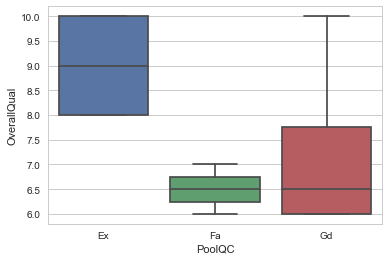

In [328]:
sns.boxplot(x = df_na["PoolQC"], y = df_na["OverallQual"])

In [329]:
df_pool_qual = pd.DataFrame(df_pool, columns = ["PoolArea", "PoolQC", "OverallQual"] )
df_pool_qual

,PoolArea,PoolQC,OverallQual
197,512,Ex,8
810,648,Fa,6
1170,576,Gd,6
1182,555,Ex,10
1298,480,Gd,10
1386,519,Fa,7
1423,738,Gd,6
1974,144,Ex,10
2420,368,NaN,4
2503,444,NaN,6


### 0-1-2. MiscFeature

- MiscVal가 없는 경우 : MiscFeature None으로 처리 
- MiscFeature가 Shed,other 이지만 0인 경우: Shed와 other 의 평균값으로 대체 
- MiscVal가 17000이고 MiscFeature가 Na인 경우: MiscVal의 range에 해당되는 Gar2로 대체 

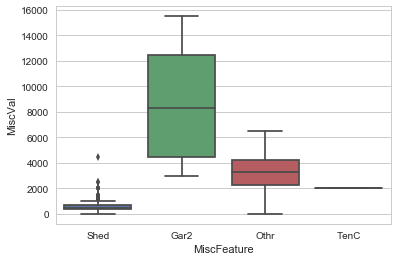

In [330]:
sns.boxplot(x = df_na["MiscFeature"], y = df_na["MiscVal"])

### 0-1-3. LotFrontage

- LotFrontage는 LotShape, LotConfig를 고려해서 해당되는 median값으로 대체 

In [331]:
df_na.pivot_table(values="LotFrontage", index=["LotShape"], columns=["LotConfig"], aggfunc=np.median)

LotConfig,Corner,CulDSac,FR2,FR3,Inside
LotShape,,,,,
IR1,92.0,50.0,60.0,80.5,71.0
IR2,96.0,47.5,44.5,NaN,66.0
IR3,158.5,113.5,NaN,NaN,66.0
Reg,74.0,33.0,64.5,65.0,65.0


### 0-1-4. Garage-related features

- Garage가 없는 경우 : None 클래스 생성
- Garage Yearbuilt인 경우 : YearRemodbuilt 년도로 대체

### 0-1-5. Basement-related features

- BsmtFinSF1 +	BsmtFinSF2	+ BsmtUnfSF	= TotalBsmtSF
- Basement(FinType 1, 2, Qual, condition, Exposure)가 모두 Nan인 경우 : None 클래스 생성 
- Basement가 있음에도 Quality, Condition이 없은 경우 : 최빈값으로 대체 (TA) 
- Basement halfbath, fullbath: basement가 없는 경우 : 0으로 대체 

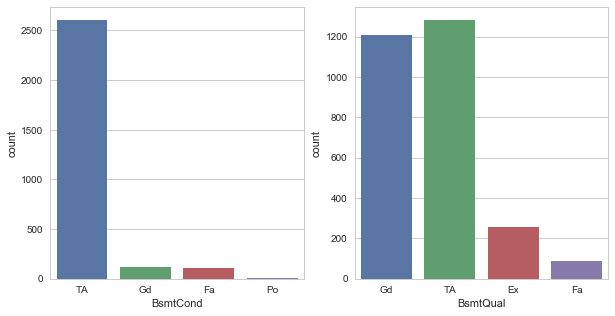

In [332]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.countplot(df_na["BsmtCond"], ax = axes[0])
sns.countplot(df_na["BsmtQual"], ax =axes[1])
plt.show()

### 0-1-6. MasVeneer-related features

- MasVnrType과 MasVnrArea과 같이 Nan인 경우: None과 0으로 대체
- MasVnrArea가 있는데 Type이 Nan인 경우는 None을 제외한 mode값 BrkFace로 대체 

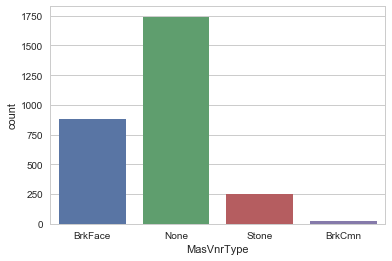

In [333]:
sns.countplot(df_na["MasVnrType"])

### 0-1-7. FireplaceQu, Fence, Alley

- None cagtegory으로 분류

### 0-1-8. MsZoning, Utilities, Functional etc.

- MsZoing : mode값 'RL'를 사용

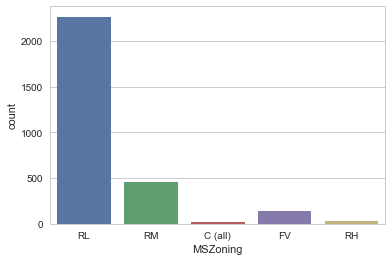

In [334]:
sns.countplot(df_na["MSZoning"])

- Utitlites : mode값 'AllPub'를 사용

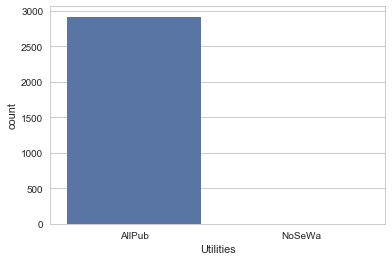

In [335]:
sns.countplot(df_na["Utilities"])

- Functional : mode값 'Typ'를 사용

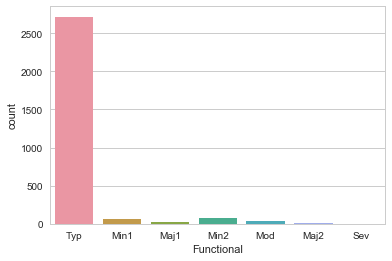

In [336]:
sns.countplot(df_na["Functional"])

## 0-2. Feature Transformation

### 0-2-1. Logarithm

#### SalePrice

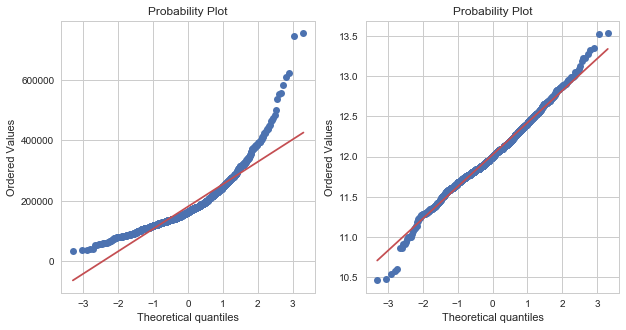

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(np.exp(df_train["SalePriceLog"]), plot = axes[0])
sp.stats.probplot(df_train["SalePriceLog"], plot = axes[1])

plt.show()

#### LotFrontage

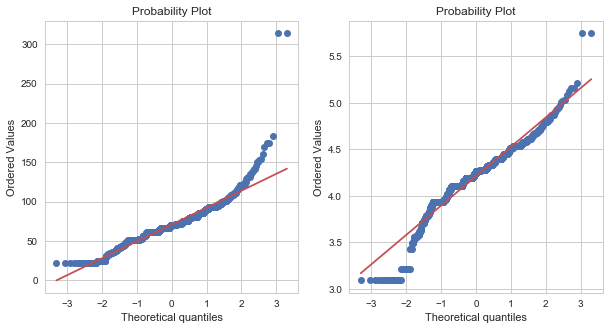

In [338]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(np.exp(df_train["LotFrontageLog"]), plot = axes[0])
sp.stats.probplot(df_train["LotFrontageLog"], plot = axes[1])

plt.show()

#### LotArea

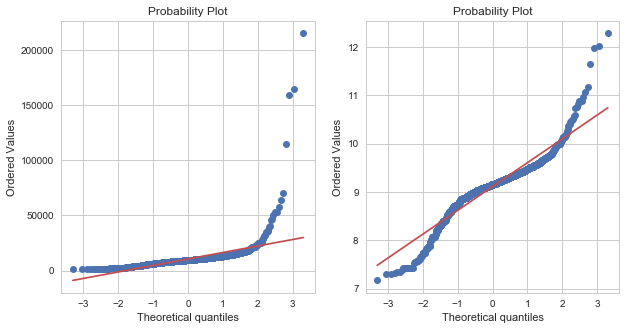

In [339]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(np.exp(df_train["LotAreaLog"]), plot = axes[0])
sp.stats.probplot(df_train["LotAreaLog"], plot = axes[1])

plt.show()

#### FirstFlrSF

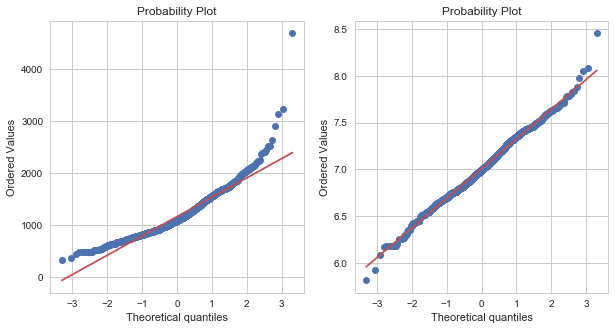

In [340]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(np.exp(df_train["FirstFlrSFLog"]), plot = axes[0])
sp.stats.probplot(df_train["FirstFlrSFLog"], plot = axes[1])

plt.show()

#### GrLivArea

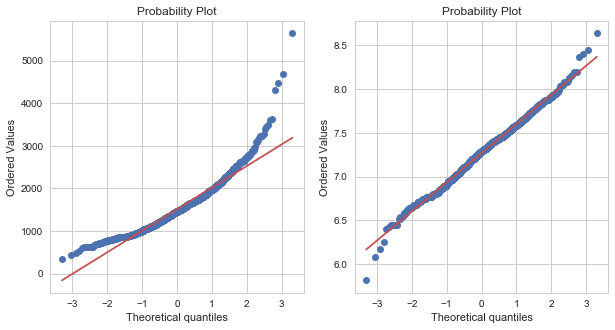

In [341]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(np.exp(df_train["GrLivAreaLog"]), plot = axes[0])
sp.stats.probplot(df_train["GrLivAreaLog"], plot = axes[1])

plt.show()

### 0-2-2. Scaling

In [342]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)
print(len(numeric_list))

32


In [343]:
df_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_scale_numeric[c+"Scale"] = scale(df_train[c])

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## 0-3. Delete Features

In [344]:
df_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_scale_numeric.drop("GrLivAreaLogScale", axis = 1, inplace = True)

df_scale_numeric["SalePriceLog"] = df_train["SalePriceLog"]

### 0-3-1. VIF

In [345]:
df_X0 = df_scale_numeric.copy()
df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [variance_inflation_factor(df_X0.values, i) for i in range(df_X0.shape[1])]
df_vif["features"] = df_X0.columns

df_vif.sort_values(by = "VIF Factor", ascending = False, inplace=True)
df_vif.reset_index(drop=True, inplace=True)
df_vif

,VIF Factor,features
0,5.636438,GarageAreaScale
1,5.410893,GarageCarsScale
2,5.173915,YearBuiltScale
3,5.111513,SecondFlrSFScale
4,5.074890,FirstFlrSFLogScale
5,4.866382,GarageYrBltScale
6,4.659438,TotRmsAbvGrdScale
7,4.516974,BsmtFinSF1Scale
8,3.464309,BsmtUnfSFScale
9,2.849796,FullBathScale


# 1. Cleaning Numeric data

## 1-1. Cleaing the numueric data using t-test

In [346]:
numeric_list = list(df_scale_numeric.columns)
numeric_list.remove("SalePriceLog")

In [347]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, None, False), df_scale_numeric)
result = model.fit()
ttest = result.pvalues
ttest.sort_values(ascending = False, inplace = True)
ttest_list = list(ttest.index)
ttest.head(10)

OpenPorchSFScale       0.977612
GarageYrBltScale       0.833024
GarageAreaScale        0.708739
MiscValScale           0.667096
LotFrontageLogScale    0.615688
BsmtHalfBathScale      0.321010
ThreeSsnPorchScale     0.246489
HalfBathScale          0.136053
LowQualFinSFScale      0.116791
MasVnrAreaScale        0.072925
dtype: float64

In [348]:
# cross validation
df_y_test = df_scale_numeric["SalePriceLog"]
r2_test_list = []

for i in range(len(ttest_list)-1):
    df_X_test = df_scale_numeric[ttest_list[i:-1]]
    model = LinearRegression(fit_intercept = True)
    
    r2_sum = cross_val_score(model, df_X_test, df_y_test, scoring="r2", cv=5).sum()
    r2_test = r2_sum / 5
    r2_test_list.append(r2_test)

In [349]:
np.array(r2_test_list)

array([ 0.81679877,  0.81781677,  0.81804654,  0.82038784,  0.82103218,
        0.82180218,  0.82215672,  0.82292433,  0.82273581,  0.8223479 ,
        0.82201871,  0.82252138,  0.82204421,  0.8219008 ,  0.82247012,
        0.82232128,  0.82171235,  0.82074863,  0.8190438 ,  0.81730951,
        0.81311136,  0.81536134,  0.79794047,  0.79380904,  0.78299192,
        0.73071933,  0.70285149,  0.57918392,  0.36631022])

(0.8, 0.85)

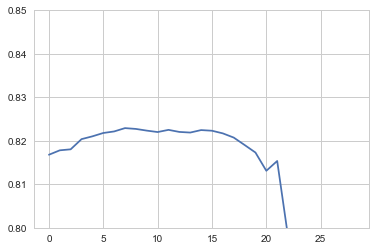

In [350]:
r2_test_list = np.array(r2_test_list)
r2_test_idx = np.where(r2_test_list > 0)
plt.plot(np.arange(len(ttest_list)-1)[r2_test_idx[0]], r2_test_list[r2_test_idx[0]])
plt.ylim([0.8, 0.85])

In [351]:
#remove
numeric_list = ttest_list[9:-1]

# 2. Cleaning the categorical data using one-way-table

## 2-1. Make dummy datas

In [352]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_scale_cate = pd.concat([df_scale_numeric, df_train[categoric_list]], axis = 1)
df_scale_cate_dummy = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)

len(categoric_list), len(categoric_dummy_list), df_scale_cate.shape, df_scale_cate_dummy.shape 

(48, 318, (1460, 78), (1460, 348))

## 2-2. One-way table

In [353]:
df_one_anova_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula("SalePriceLog ~ C({})".format(c), data=df_train)
    result = model.fit()
    df_tmp=sm.stats.anova_lm(result)
    df_one_anova_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}   

df_one_anova_Fvalue.sort_values(by=["Fvalue"], ascending=False, inplace=True)
df_one_anova_Fvalue.reset_index(drop=True, inplace=True)
df_one_anova_Fvalue.head(8)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,name,Fvalue
0,Utilities,0.629609
1,YrSold,0.565639
2,MoSold,0.449661
3,LandSlope,0.338834
4,Street,0.028380
5,Condition2,0.013820
6,PoolQC,0.007695
7,MiscFeature,0.006060


In [354]:
over_one_Fvalue_list = list(df_one_anova_Fvalue[:6]["name"])
# over_one_Fvalue_list

In [355]:
over_one_Fvalue_dummy_list=[]
for c in over_one_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_one_Fvalue_dummy_list.append(a)
        
# over_one_Fvalue_dummy_list

In [356]:
# 제거 high one-way Fvalue
for c in over_one_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_one_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

In [357]:
len(categoric_list), len(over_one_Fvalue_list), len(categoric_dummy_list), len(over_one_Fvalue_dummy_list)

(42, 6, 286, 32)

## 2-3. Delete categoric data using ANOVA

In [359]:
categoric_test_list = categoric_list.copy()
isLoop = True

while isLoop:
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, categoric_test_list, True), df_scale_cate)
    result = model.fit()

    df_anova_cate = sm.stats.anova_lm(result, typ = 2)
    
    rm_idx_list = []
    max_value = df_anova_cate["PR(>F)"][0]
    tmp_idx_list = list(df_anova_cate[df_anova_cate["PR(>F)"] > 0.01].index)
    tmp_value_list = list(df_anova_cate[df_anova_cate["PR(>F)"] > 0.01].values)
    
    for idx in tmp_idx_list:
        if re.match(r'C\((\w+)\)\S*', idx):
            tmp_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", idx)
            rm_idx_list.append(tmp_index)
    
    if len(rm_idx_list) > 0:
        for idx in rm_idx_list:
            categoric_test_list.remove(idx)
            isLoop = True
    else:
        isLoop = False
    
print(categoric_test_list)
# df_ttest_cate_dummy.sort_values(by = ["t-value"], inplace = True)
# df_ttest_cate_dummy.reset_index(drop=True, inplace=True)

['Alley', 'BsmtCond', 'BsmtExposure', 'Condition1', 'Electrical', 'Exterior1st', 'Functional', 'MSZoning', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofMatl', 'SaleCondition']


In [360]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, categoric_test_list, True), df_scale_cate)
result = model.fit()
df_anova_cate = sm.stats.anova_lm(result, typ = 2)
df_anova_cate

,sum_sq,df,F,PR(>F)
C(Alley),29.554029,3.0,816.084885,6.408829e-302
C(BsmtCond),3.555941,4.0,73.643509,1.805823e-56
C(BsmtExposure),0.184842,4.0,3.828077,4.234195e-03
C(Condition1),0.525309,8.0,5.439574,9.088958e-07
C(Electrical),2.031209,4.0,42.066313,2.861903e-33
C(Exterior1st),0.519860,14.0,3.076082,1.000683e-04
C(Functional),0.707204,6.0,9.764128,1.496998e-10
C(MSZoning),0.918050,4.0,19.012796,3.196749e-15
C(Neighborhood),1.749164,24.0,6.037530,4.007256e-18
C(OverallCond),14.147121,8.0,146.493375,6.262589e-177


In [ ]:
categoric_dummy_test_list=[]
for c in categoric_test_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        categoric_dummy_test_list.append(a)

In [ ]:
categoric_list = categoric_test_list.copy()
categoric_dummy_list = categoric_dummy_test_list.copy()

# 3. Stepwise method : Backward Elimination

In [ ]:
numeric_test_list = numeric_list.copy()
categoric_dummy_test_list = categoric_dummy_list.copy()

## 3-1.한번에 제거

In [ ]:
debug = True

num_iter = 0
isLoop = True

while(isLoop):
    num_iter += 1

    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_test_list + categoric_dummy_test_list, None, True), df_scale_cate_dummy)
    result = model.fit()

    pvalues = result.pvalues
    pvalues.sort_values(ascending = False, inplace = True)
    max_value = pvalues.values[0]
    rm_index_list = list(pvalues[pvalues > 0.01].index)
    rm_value_list = list(pvalues[pvalues > 0.01].values)
    
    if(len(rm_index_list) > 0):
        # C()제거
        rm_cate_list = []
        rm_numeric_list = []
        
        for idx in rm_index_list:
            if "_" in list(idx):
                tmp_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", idx)
                rm_cate_list.append(tmp_index)
            else:
                rm_numeric_list.append(idx)

        if len(rm_numeric_list) > 0:
            for index in rm_numeric_list:
                numeric_test_list.remove(index)
        
        if len(rm_cate_list) > 0:
            for index in rm_cate_list:
                categoric_dummy_test_list.remove(index)
        
        if debug == True:
            print("{} 단계 제거 목록: ".format(num_iter))
            for i in range(len(rm_index_list)):
                print("({}, {}) \n".format(rm_index_list[i], rm_value_list[i]), end=" ")
            print()

        isLoop = True
    else:
        isLoop = False

print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
print("numeric list : ", numeric_test_list)
print("categoric list : ", categoric_dummy_test_list)
print("{} {} -> {} {}".format(len(numeric_list), len(categoric_dummy_list), len(numeric_test_list), len(categoric_dummy_test_list)))

In [ ]:
numeric_list = numeric_test_list.copy()
categoric_dummy_list = categoric_dummy_test_list.copy()

Kaggle : 0.13085

# 4. Remove Outlier

In [ ]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list + categoric_dummy_list, None, False), df_scale_cate_dummy)
result = model.fit()

predict = result.predict(df_scale_cate_dummy).values
target = df_scale_cate_dummy["SalePriceLog"].values

## 4-1. Leverage - Standard residual

### 4-1-1. Leverage

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag
plt.figure(figsize=(10,2))
plt.stem(hat)
plt.show()

### 4-1-2. Standard residual

In [ ]:
plt.figure(figsize=(10,2))
plt.stem(result.resid_pearson)
plt.show()

## 4-2. Cook's distance

In [ ]:
influence = result.get_influence()

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(target) -len(numeric_list+categoric_dummy_list) +1 - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

outlier_idx_list = idx
outlier_cooks_d2_list = cooks_d2[idx]
outlier_hat_list = hat[idx]
outlier_resid_list = result.resid_pearson[idx]

df_cooks_d2 = pd.DataFrame(index = outlier_idx_list, columns = ["cooks", "Levearge", "Residual"])
df_cooks_d2["cooks"] = outlier_cooks_d2_list
df_cooks_d2["Levearge"] = outlier_hat_list
df_cooks_d2["Residual"] = outlier_resid_list

In [ ]:
df_cooks_d2.sort_values(by=["cooks"], ascending = False, inplace = True)
df_cooks_d2.head(20)

## 3-4. Remove outlier

In [ ]:
df_train_tmp = df_scale_cate_dummy.copy()
df_train_tmp.reset_index(inplace = True)

In [ ]:
rmse_list = []
r2_list = []

In [ ]:
for idx in list(df_cooks_d2.index[:19]):
    df_train_tmp = df_train_tmp[df_train_tmp["index"] != idx]
    
print(df_train_tmp.shape)
print(df_scale_cate_dummy.shape)

## 3-5. Compare Models

In [ ]:
model_origin = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list + categoric_dummy_list, None, True), df_scale_cate_dummy)
result_origin = model_origin.fit()
model_remove = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list + categoric_dummy_list, None, True), df_train_tmp)
result_remove = model_remove.fit()

target_origin = df_scale_cate_dummy["SalePriceLog"].values
predict_origin = result_origin.predict(df_scale_cate_dummy).values
target_remove = df_train_tmp["SalePriceLog"].values
predict_remove = result_remove.predict(df_train_tmp).values

### 3-5-1. Predict - Target plot

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].scatter(target_origin, predict_origin)
axes[0].set_title("Origin")
axes[1].scatter(target_remove, predict_remove)
axes[1].set_title("Remove")

### 3-5-2. residual q-q plot

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sp.stats.probplot(result_origin.resid, plot =axes[0])
sp.stats.probplot(result_remove.resid, plot =axes[1])
axes[0].set_title("Origin")
axes[1].set_title("Remove")
plt.show()

### 3-5-3. R2 Score

In [ ]:
result_remove.summary()

In [ ]:
print("r2 origin : {}, r2 remove : {}".format(result_origin.rsquared, result_remove.rsquared)) 

plt.bar(["r2 origin", "r2 remove"], [result_origin.rsquared, result_remove.rsquared])
plt.ylim([0.9, 0.96])

In [ ]:
# copy df_train_tmp
df_scale_numeric = df_train_tmp[numeric_list]
df_scale_numeric["SalePriceLog"] = df_train_tmp["SalePriceLog"]
df_train_dummy = df_train_tmp[categoric_dummy_list]

In [ ]:
# remove하면서 생기는 필요없는 속성 제거
rm_categoric_list = ["RoofMatl_ClyTile", "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll", "Exterior1st_AsphShn", "Exterior1st_BrkComm", "Functional_Sev"]

for c in rm_categoric_list:
    categoric_dummy_list.remove(c) 

In [ ]:
df_scale_numeric.reset_index(drop=True, inplace=True)
df_train_dummy.reset_index(drop=True, inplace=True)

In [ ]:
# make all_features
df_all_feature = df_scale_numeric.copy()

# make all feature dataframe (scale + scale ** 2 + scale ** 3. categoric)
df_all_feature = pd.concat([df_scale_numeric[numeric_list], df_train_dummy[categoric_dummy_list]], axis = 1)
df_all_feature = pd.concat([df_all_feature, df_scale_numeric["SalePriceLog"]], axis = 1)
print(df_all_feature.shape)
print(len(numeric_list), len(categoric_dummy_list), 1)

In [ ]:
all_feature_list = list(df_all_feature.columns)
all_feature_list.remove("SalePriceLog")

In [ ]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", all_feature_list, None, False), df_all_feature)
result = model.fit()

# 5. Multinomial regression - Lasso, Ridge, Elastic Net

In [ ]:
#make square data
df_scale_pow2 = pd.DataFrame()
for c in numeric_list:
    if c == "SalePriceLog":
        continue 
    df_scale_pow2[c+"pow2"] = df_scale_numeric[c].values ** 2
df_scale_pow2.shape

df_all_feature = pd.concat([df_all_feature, df_scale_pow2], axis = 1)
all_feature_list = list(df_all_feature.columns)
all_feature_list.remove("SalePriceLog")

## 5-1. Lasso Regression

In [ ]:
df_y_lasso = df_all_feature["SalePriceLog"]
df_X_lasso = df_all_feature[all_feature_list]

In [ ]:
# setting lasso regression
alpha_lasso_list = np.logspace(-6, -1, 400)

In [ ]:
# params_lasso_list = [] # lasso 확인 시 사용
# r2_lasso_list = []
# debug = False

# for idx, a in enumerate(alpha_lasso_list):
#     model = Lasso(alpha=a, fit_intercept = True).fit(df_X_lasso, df_y_lasso)
    
#     r2_sum = cross_val_score(model, df_X_lasso, df_y_lasso, scoring="r2", cv=3).sum()
#     r2_test = r2_sum / 3
            
#     r2_lasso_list.append(r2_test)
#     params_lasso_list.append(model.coef_)
    
#     if(debug == True):
#         print("{} 차 시도 !!".format(idx))
#         print("r2_lasso : {}".format(r2_test))
#         print()
        
# print("끝!!")

In [ ]:
# # 결과 pickle 저장
# pickle.dump(params_lasso_list, open("data/lasso_params.p", "wb"))
# pickle.dump(r2_lasso_list, open("data/lasso_r2.p", "wb"))
# pickle.dump(alpha_lasso_list, open("data/lasso_alpha.p", "wb"))

# 결과 pickle 불러오기
params_lasso_list = pickle.load(open("data/lasso_params.p", "rb"))
r2_lasso_list = pickle.load(open("data/lasso_r2.p", "rb"))
alpha_lasso_list = pickle.load(open("data/lasso_alpha.p", "rb"))

In [ ]:
# plot about weight

df_lasso_params = pd.DataFrame(params_lasso_list, index = alpha_lasso_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_lasso_params)

plt.show()

In [ ]:
# plot r2 score
r2_lasso_list = np.array(r2_lasso_list)
r2_lasso_idx = np.where(r2_lasso_list > 0.928)
r2_lasso_idx[0]

plt.plot(r2_lasso_idx[0], r2_lasso_list[r2_lasso_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [ ]:
r2_lasso_list[150:160]

In [ ]:
alpha_lasso_list[152]

In [ ]:
a = np.array(all_feature_list)

kaggle : 0.12825

## 5-2. Ridge Regression

In [ ]:
df_y_ridge = df_all_feature["SalePriceLog"]
df_X_ridge = df_all_feature[all_feature_list]

In [ ]:
df_all_feature.shape

In [ ]:
# setting Ridge regression
alpha_ridge_list = np.logspace(-2, 1, 400)

In [ ]:
# params_ridge_list = [] # lasso 확인 시 사용
# r2_ridge_list = []
# debug = False

# for idx, a in enumerate(alpha_ridge_list):
#     model = Ridge(alpha=a, fit_intercept = True).fit(df_X_ridge, df_y_ridge)
    
#     r2_sum = cross_val_score(model, df_X_ridge, df_y_ridge, scoring="r2", cv=3).sum()
#     r2_test = r2_sum / 3
            
#     r2_ridge_list.append(r2_test)
#     params_ridge_list.append(model.coef_)
    
#     if(debug == True):
#         print("{} 차 시도 !!".format(idx))
#         print("r2_ridge : {}".format(r2_test))
#         print()
# print("끝!!")

In [ ]:
# # 결과 pickle 저장
# pickle.dump(params_ridge_list, open("data/ridge_params.p", "wb"))
# pickle.dump(r2_ridge_list, open("data/ridge_r2.p", "wb"))
# pickle.dump(alpha_ridge_list, open("data/ridge_alpha.p", "wb"))

# 결과 pickle 불러오기
params_ridge_list = pickle.load(open("data/ridge_params.p", "rb"))
r2_ridge_list = pickle.load(open("data/ridge_r2.p", "rb"))
alpha_ridge_list = pickle.load(open("data/ridge_alpha.p", "rb"))

In [ ]:
# plot about weight
df_ridge_params = pd.DataFrame(params_ridge_list, index = alpha_ridge_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_ridge_params)

plt.show()

In [ ]:
# plot r2 score
r2_ridge_list = np.array(r2_ridge_list)
r2_ridge_idx = np.where(r2_ridge_list > 0.9288)
r2_ridge_idx[0]

plt.plot(r2_ridge_idx[0], r2_ridge_list[r2_ridge_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [ ]:
r2_ridge_list[160:170]

In [ ]:
alpha_ridge_list[165]

Kaggle : 0.12528

## 5-3 Elastic net Regression

In [ ]:
df_y_elastic = df_all_feature["SalePriceLog"]
df_X_elastic = df_all_feature[all_feature_list]

In [ ]:
# setting ElasticNet regression
alpha_elastic_list = np.logspace(-6, -2, 400)

In [ ]:
# params_elastic_list = [] # lasso 확인 시 사용
# r2_elastic_list = []
# debug = False

# params_elastic_lists = []
# r2_elastic_lists = []


# for idx, a in enumerate(alpha_elastic_list):
#     model = ElasticNet(alpha=a, l1_ratio=0.3, fit_intercept = True).fit(df_X_elastic, df_y_elastic)

#     r2_sum = cross_val_score(model, df_X_elastic, df_y_elastic, scoring="r2", cv=3).sum()
#     r2_test = r2_sum / 3

#     r2_elastic_list.append(r2_test)
#     params_elastic_list.append(model.coef_)

#     if debug == True:
#         print("{} 차 시도 !!".format(idx))
#         print("r2_elastic : {}".format(r2_test))
#         print()

# params_elastic_lists.append(params_elastic_list)
# r2_elastic_lists.append(r2_elastic_list)

# print("끝!!")

In [ ]:
# # 결과 pickle 저장
# pickle.dump(params_elastic_list, open("data/elastic_params.p", "wb"))
# pickle.dump(r2_elastic_list, open("data/elastic_r2.p", "wb"))
# pickle.dump(alpha_elastic_list, open("data/elastic_alpha.p", "wb"))

# 결과 pickle 불러오기
params_elastic_list = pickle.load(open("data/elastic_params.p", "rb"))
r2_elastic_list = pickle.load(open("data/elastic_r2.p", "rb"))
alpha_elastic_list = pickle.load(open("data/elastic_alpha.p", "rb"))

In [ ]:
# plot about weight
df_elastic_params = pd.DataFrame(params_elastic_list, index = alpha_elastic_list)
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_elastic_params)

plt.show()

In [ ]:
# plot r2 score
r2_elastic_list = np.array(r2_elastic_list)
r2_elastic_idx = np.where(r2_elastic_list > 0.9298)
r2_elastic_idx[0]

plt.plot(r2_elastic_idx[0], r2_elastic_list[r2_elastic_idx])
plt.xlabel("iter_num")
plt.ylabel("test_r2")

In [ ]:
r2_elastic_list[219:225]

In [ ]:
alpha_elastic_list[220]

alpha = 0.3, Kaggle : 0.12682

alpha = 0.5, kaggle :  0.12765

### Result
Ridge를 사용했을 때 성능 0.12578 -> 0.12528

In [ ]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmp_numeric_list = list(df_test.select_dtypes(include=numerics).columns)

df_test_scale_numeric = pd.DataFrame()
# scale지정
for c in tmp_numeric_list:
    if c == "Id":
        continue
    df_test_scale_numeric[c+"Scale"] = scale(df_test[c])
    
df_test_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_test_scale_numeric.drop("GrLivAreaLogScale", axis = 1, inplace = True)

df_test_all_feature = pd.concat([df_test_scale_numeric, df_test_dummy[categoric_dummy_list]], axis = 1)
df_test_all_feature.shape

# 6. Result

In [ ]:
# train, test dataframe 생성
df_X_train = df_train_tmp.filter(items = numeric_list + categoric_dummy_list)
df_y_train = df_train_tmp["SalePriceLog"]
df_X_test = df_test_all_feature.filter(items = numeric_list + categoric_dummy_list)

print(df_X_train.shape, df_y_train.shape, df_X_test.shape)

In [ ]:
model = Ridge(alpha = 0.17402093740624849, fit_intercept = True).fit(df_X_train, df_y_train)
predict = model.predict(df_X_train)
target = df_y_train.values

## 6-1. Predict - Target plot

In [ ]:
plt.scatter(target, predict)

## 6-2. Residual normality

In [ ]:
residual  = (predict - target)
sp.stats.probplot(residual, plot =plt)
plt.show()

## 6-3. Kaggle score

kaggle score : 0.12528

![Alt text](kaggle_score.PNG)

## Submit

In [ ]:
predict = model.predict(df_X_test)

predict = np.exp(predict)
print(predict)

# sumit 만들기
df_sumit = pd.DataFrame(columns = ["Id", "SalePrice"])
df_sumit["Id"] =df_test["Id"]
df_sumit["SalePrice"] = predict

df_sumit.to_csv("submit/submit.csv", index = False)